# Computer Vision Hw1

In [1]:
from cmath import exp, pi
from operator import concat
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
from skimage import color
from scipy.spatial import distance

## Gaussian filter window
formula: G(x,y)=exp(−x^2+y^2)/2(σ^2)

In [2]:
def Gaussian(x,y,sigma=5):
    gau = (1.0 / 2.0*pi*sigma**2 )* np.exp(-((x**2 + y**2) / (2.0 * sigma**2)))
    return gau/gau.sum()

In [3]:
def _filter(m,n):
    y,x = np.ogrid[-m//2+1:m//2+1,-n//2+1:n//2+1]
    G = Gaussian(x,y)
    return G

## Sobel Operator

*  Sobel gradient x
*  Sobel gradient y
*  Direction
*  magnitude

In [4]:
def sobel(img):
    #gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = img/255.0
    vertical = np.array([[-1 ,0,1], [-2,0,2], [-1,0,1]]) * 1.0/8.0
    # sobel gradient x
    Gx = signal.convolve2d(gray_img, vertical)
    horizontal = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) * 1.0/8.0
    # sobel gradient y
    Gy = signal.convolve2d(gray_img, horizontal)
    # magnitude
    G = np.sqrt(np.square(Gx) + np.square(Gy))
    G *= 255.0 / G.max()
    plt.imshow(G, cmap="gray")
    plt.show()

    # Direction
    theta = np.arctan2(Gx, Gy)
    hsv = np.zeros((G.shape[0], G.shape[1], 3))
    hsv[..., 0] = (theta+ np.pi) / (2 * np.pi)
    hsv[..., 1] = np.ones((G.shape[0], G.shape[1]))
    hsv[..., 2] = (G - G.min()) / (G.max() - G.min())
    rgb = color.hsv2rgb(hsv)
    plt.imshow(rgb, cmap="gray")
    plt.savefig('direction.jpg')
    plt.show()
    return Gx, Gy, G, theta, rgb

## Structure Tensor
* Return Ixx Ixy Iyy and responce

In [5]:
def structure_matrix(size, dx, dy):
    # window size
    filter_ = np.ones((size,size))
    # Ixx
    Axx = signal.convolve2d(dx * dx, filter_, mode="same")
    # Iyy
    Ayy = signal.convolve2d(dy * dy, filter_, mode="same")
    # Ixy
    Axy = signal.convolve2d(dx * dy, filter_, mode="same")

    landa2, responce = cal_eigen(Axx, Axy, Ayy)
    landa2 /= np.max(landa2)
    landa2[responce < np.average(responce)] = 0.0
    plt.imshow(landa2, cmap="gray")
    plt.show()
    
    return Axx, Axy, Ayy, responce, landa2

1.  Eigen value = landa1 * landa2  /  landa2
2.  We can easily get determine approach to eigen value
3.  Trace is approach to trace
4.  then we have landa2

In [6]:
def cal_eigen(Axx, Axy, Ayy, k=0.04):
    det = Axx * Ayy - Axy * Axy
    trace = Axx + Ayy 

    landa2 = det/(trace+1e-9)
    responce = det - k * (trace * trace)

    return landa2, responce

### Non-maximum suppresion

#### 2 requirements
* Find points with large response
* Choose those points where landa- is a local maximum as features

In [40]:
def NMS(r, threshold = 0.0001):
    # larger than threshold
    mask1 = (r > threshold)
    # local maximum
    mask2 = np.full((r.shape[0], r.shape[1]), True)
    size = 5
    for i in range(0, r.shape[0], size):
        for j in range(0, r.shape[1], size):
            local_window = r[i:i+5,j:j+5]
            x,y = np.unravel_index(local_window.argmax(), local_window.shape)
            local_mask = np.full((local_window.shape[0], local_window.shape[1]), False)
            local_mask[x,y] = True
            mask2[i:i+5, j:j+5] = local_mask      
    mask =  (mask1 & mask2) 

    # plot picture
    x,y = np.nonzero(mask)
    return x,y

#### combine 2 images in one

In [8]:
def plot_images(kp_left_img, kp_right_img): 
    total_kp = np.concatenate((kp_left_img, kp_right_img), axis=1)
    plt.imshow(total_kp)
    return total_kp

#### plot the matches between 2 images on merged image

In [9]:
def plot_matches(matches, img):
    match_img = img.copy()
    offset = img.shape[1]/2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8'))
    
    ax.plot(matches[:, 0], matches[:, 1], 'xr')
    ax.plot(matches[:, 2] + offset, matches[:, 3], 'xr')
     
    ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            'r', linewidth=0.5)
    plt.savefig('matches_.png')
    plt.show()

### SIFT

* Keypoints
* decribtor
* calculate similarity between each features **a.b / |a| * |b| **

In [10]:
def SIFT(img1, img2, gray1, gray2):
    # For same shape
    gray1.resize((2032,1536),refcheck=False)
    img1.resize((2032,1536,3),refcheck=False)
    # descriptor
    sift1 = cv2.SIFT_create(contrastThreshold=0.21, edgeThreshold=10, sigma=1.6)
    sift2 = cv2.SIFT_create(contrastThreshold=0.2, edgeThreshold=30, sigma=1.6)
    kp1, des1 = sift1.detectAndCompute(gray1.astype('uint8'),None)
    kp2, des2 = sift2.detectAndCompute(gray2.astype('uint8'),None)
    # plot merged image
    img3 = plot_images(img1, img2)
    img1 = cv2.drawKeypoints(gray1.astype('uint8'),kp1,img1, color=(255,100,255))
    img2 = cv2.drawKeypoints(gray2.astype('uint8'),kp2,img2, color=(255,100,255))
    plt.imshow(img1, cmap="gray")
    plt.show()
    plt.imshow(img2, cmap="gray")
    plt.show()
    print("[INFO] la_notredame of keypoints detected: {}".format(len(kp1)))
    print("[INFO] lb_notredame of keypoints detected: {}".format(len(kp2)))
    print("[INFO] feature vector shape: {}".format(des1.shape))
    print("[INFO] feature vector shape: {}".format(des2.shape))
    cv2.imwrite('1a_notredame_keypoints.jpg', img1)
    cv2.imwrite('1b_notredame_keypoints.jpg', img2)
    
    # SIFT feature matching
    # similarity
    similarity = np.zeros((des1.shape[0], des2.shape[0]))
    for i in range(des1.shape[0]):
        for j in range(des2.shape[0]):
            # similarity[i][j] = (np.sqrt(np.sum((np.power(a-b,2) for a, b in zip(des1[i], des2[j])))))
            similarity[i][j] = np.dot(des1[i], des2[j]) / (np.linalg.norm(des1[i]) * np.linalg.norm(des2[j]))

    return similarity, img3, kp1, des1, kp2, des2, img1, img2

In [11]:
def match(similarity, kp1, kp2):
    # 2-nearest neighbor
    k = 2
    matches = []
    nn = []
    for idx in range(similarity.shape[0]):
        local = similarity[idx]
        max2min = sorted(local, reverse=True)
        k_nn = np.zeros(k)
        # find index
        best = np.where(local==max2min[0])[0]
        best = list(kp1[idx].pt + kp2[int(best)].pt)
        matches.append(best)
        for i in range(k-1):
            k_nn[i] = np.where(local==max2min[i+1])[0][0]
            match = list(kp1[idx].pt + kp2[int(k_nn[i])].pt)
            nn.append(match)
    print("The number of matches:",len(matches))
    matches = np.array(matches)
    return matches

In [12]:
def improve_match(similarity ,kp1, kp2):
    # 2-nearest-neighbor
    k = 2
    
    matches = []
    legal = True
    for idx in range(similarity.shape[0]):
        legal = True
        local = similarity[idx]
        max2min = sorted(local, reverse=True)
        k_nn = np.zeros(k)
        # find index
        best = np.where(local==max2min[0])[0]
        good = []
        good.append(list(kp1[idx].pt + kp2[int(best)].pt))
        for i in range(k-1):
            k_nn[i] = np.where(local==max2min[i])[0][0]
            if (max2min[0]*0.92 > max2min[i+1]):
                match = list(kp1[idx].pt + kp2[int(k_nn[i])].pt)
                good.append(match)
            else:
                legal=False
        if legal == True:
            matches= matches + good
            
    print("The number of matches:",len(matches))
    matches = np.array(matches)
    return matches

# Hw  

* Load images

In [17]:
chess_img = cv2.imread("chessboard-hw1.jpg")
notredame_a = cv2.imread("1a_notredame.jpg")
notredame_b = cv2.imread("1b_notredame.jpg")
chess_img = cv2.cvtColor(chess_img, cv2.COLOR_BGR2RGB)
chess_gray = cv2.cvtColor(chess_img, cv2.COLOR_RGB2GRAY)
notredame_a_gray = cv2.cvtColor(notredame_a, cv2.COLOR_RGB2GRAY)
notredame_b_gray = cv2.cvtColor(notredame_b, cv2.COLOR_RGB2GRAY)

## 1-1

#### (a) Gaussian Smooth: Show the results of Gaussian smoothing for 𝜎=5 and kernel  size=5 and 10 respectively.

In [18]:
# ### Hw1-1 ###
""" 
# 1(a)
# Gaussian smoothing
"""
# size10
G_10 = _filter(10,10)
# size5
G_5 = _filter(10,10)
chess_conv_5 = signal.convolve2d(chess_gray, G_5)
notredame_a_conv_5 = signal.convolve2d(notredame_a_gray, G_5)
chess_conv_10 = signal.convolve2d(chess_gray, G_10)
notredame_a_conv_10 = signal.convolve2d(notredame_a_gray, G_10)
#notredame_b_conv = signal.convolve2d(notredame_b_gray, G)

# show result
# cv2.imwrite('chess_Gaussian_Blured_size5.png', chess_conv_5*255 / chess_conv_5.max())
# cv2.imwrite('chess_Gaussian_Blured_size10.png', chess_conv_10*255 / chess_conv_10.max())
# cv2.imwrite('1a_notredame_Gaussian_Blured_size5.png', notredame_a_conv_5*255 / notredame_a_conv_5.max())
# cv2.imwrite('1a_notredame_Gaussian_Blured_size10.png', notredame_a_conv_10*255 / notredame_a_conv_10.max())

#### (b) Intensity Gradient (Sobel edge detection): Apply the Sobel filters to the blurred images and compute the magnitude (2 images) and direction (2 images) of gradient. (You should eliminate weak gradients by proper threshold.)


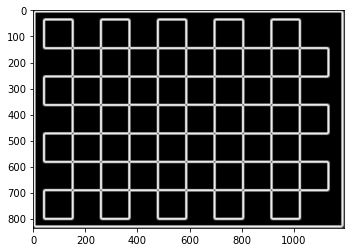

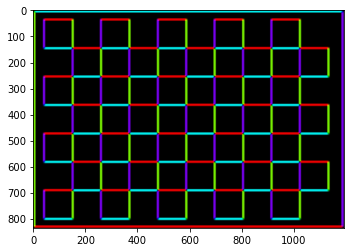

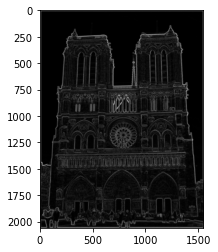

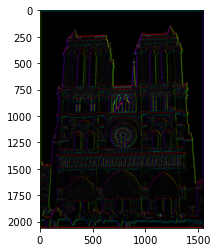

In [19]:
"""
1(b)
"""
# Intensity Gradient (Sobel edge detection)
dx_c, dy_c, magnitude_c, theta_c, direction_c = sobel(chess_conv_10)
dx_a, dy_a, magnitude_a, theta_a, direction_a = sobel(notredame_a_conv_10)
# cv2.imwrite('chess_magnitude.jpg', magnitude_c*255 / magnitude_c.max())
# cv2.imwrite('1a_notredame_magnitude.jpg', magnitude_a*255 / np.max(magnitude_a))
# cv2.imwrite('chess_direction.jpg', direction_c*255 / direction_c.max())
# cv2.imwrite('1a_notredame_direction.jpg', direction_a*255 / direction_a.max())


#### (c) Structure Tensor: Use the Sobel gradient magnitude (with Gaussian kernel size=10)  above to compute the structure tensor 𝐻 of each pixel. Show the images of the  smaller eigenvalue of 𝐻 with window size 3x3 and 5x5. (2 images)

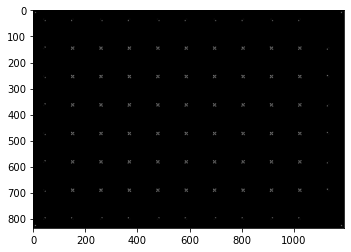

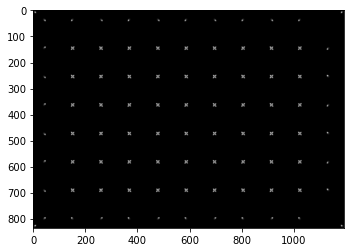

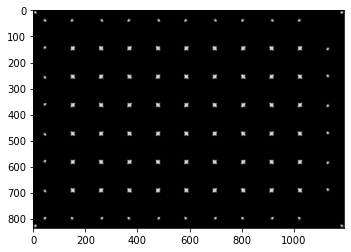

[[3.80406988e-08 2.03705966e-07 3.48514014e-07 ... 1.24793863e-07
  9.56961997e-08 1.73184990e-08]
 [2.03705966e-07 1.67026467e-06 5.59073411e-06 ... 3.00526581e-06
  8.51095964e-07 9.16968145e-08]
 [3.48514014e-07 5.59073411e-06 2.22742521e-05 ... 1.21960970e-05
  2.81037485e-06 1.14026789e-07]
 ...
 [1.24793863e-07 3.00526581e-06 1.21960970e-05 ... 6.42911041e-06
  1.47669016e-06 3.98909543e-08]
 [9.56961997e-08 8.51095964e-07 2.81037485e-06 ... 1.56448026e-06
  4.38987312e-07 4.37400458e-08]
 [1.73184990e-08 9.16968145e-08 1.14026789e-07 ... 6.25548569e-08
  4.56605821e-08 7.80564584e-09]]


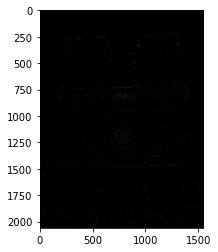

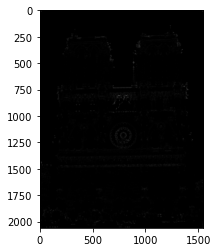

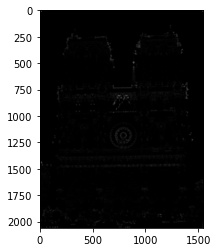

In [20]:
"""
1(c)
"""

# Structure Tensor
# Chess image
Axx_c_3,Axy_c_3,Ayy_c_3,responce_c_3, landa2_c_3 = structure_matrix(size = 3, dx=dx_c, dy=dy_c)
Axx_c_5,Axy_c_5,Ayy_c_5,responce_c_5, landa2_c_5 = structure_matrix(size = 5, dx=dx_c, dy=dy_c)
Axx_c_10,Axy_c_10,Ayy_c_10,responce_c_10, landa2_c_10 = structure_matrix(size = 10, dx=dx_c, dy=dy_c)
print(responce_c_5)
# cv2.imwrite('chess_structure_tensor_3.png', landa2_c_3*255 / landa2_c_3.max())
# cv2.imwrite('chess_structure_tensor_5.png', landa2_c_5*255 / landa2_c_5.max())
# cv2.imwrite('chess_structure_tensor_10.png', landa2_c_10*255 / landa2_c_10.max())

# 1a_notredame
Axx_a_3,Axy_a_3,Ayy_a_3,responce_a_3, landa2_a_3 = structure_matrix(size = 3, dx=dx_a, dy=dy_a)
Axx_a_5,Axy_a_5,Ayy_a_5,responce_a_5, landa2_a_5 = structure_matrix(size = 5, dx=dx_a, dy=dy_a)
Axx_a_10,Axy_a_10,Ayy_a_10,responce_a_10, landa2_a_10 = structure_matrix(size = 10, dx=dx_a, dy=dy_a)
# cv2.imwrite('1a_notredame_structure_tensor_3.png', landa2_a_3*255 / landa2_a_3.max() )
# cv2.imwrite('1a_notredame_structure_tensor_5.png', landa2_a_5*255 / landa2_a_5.max())
# cv2.imwrite('1a_notredame_structure_tensor_10.png', landa2_a_10*255 / landa2_a_10.max())


#### (d) Non-maximal Suppression: Perform non-maximal suppression on the results above  along with appropriate thresholding for corner detection. (2 images)


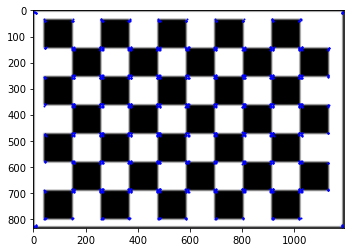

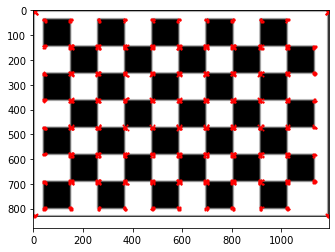

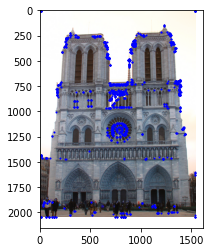

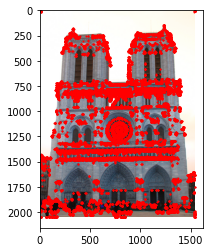

In [41]:
"""
1(d)
"""
# Chess image
#Non-maximal Suppression
# size=5
r,c =  NMS(responce_c_5)
fig, ax = plt.subplots()
ax.imshow(chess_conv_5,cmap="gray")
ax.plot(c,r,'b.', markersize=2)
plt.savefig('chess_NMS_size5.png')
plt.show()
# size=10
r,c =  NMS(responce_c_10)
fig, ax = plt.subplots()
ax.imshow(chess_conv_10,cmap="gray")
ax.plot(c,r,'r.', markersize=2)
plt.savefig('chess_NMS_size10.png')
plt.show()

# 1a_notredame image
#Non-maximal Suppression
# size=5
r,c =  NMS(responce_a_5)
fig, ax = plt.subplots()
ax.imshow(notredame_a,cmap="gray")
ax.plot(c,r,'b.', markersize=2)
plt.savefig('1a_notredame_NMS_size5.png')
plt.show()
# size=10
r,c =  NMS(responce_a_10)
fig, ax = plt.subplots()
ax.imshow(notredame_a,cmap="gray")
ax.plot(c,r,'r.', markersize=2)
plt.savefig('1a_notredame_NMS_size10.png')
plt.show()



#### (b) Experiments (Rotate and Scale):Apply the same corner detection algorithm to the rotated (by 30°) and scaled (to 0.5x) images. (2 images)

###### rotate

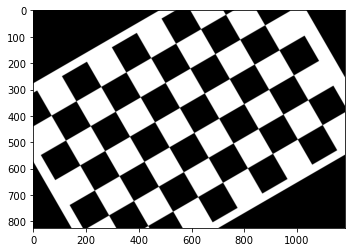

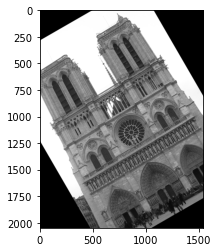

In [46]:
M = cv2.getRotationMatrix2D((chess_img.shape[1]/2,chess_img.shape[0]/2),30,1) 
chess_image_rotate = cv2.warpAffine(chess_img,M,(chess_img.shape[1],chess_img.shape[0])) 
chess_image_rotate = cv2.cvtColor(chess_image_rotate, cv2.COLOR_RGB2GRAY)
plt.imshow(chess_image_rotate, cmap="gray")
plt.savefig('chess_rotate.png')
plt.show()


#a_notredame = cv2.rotate(notredame_a, cv2.ROTATE_30)
M = cv2.getRotationMatrix2D((notredame_a.shape[1]/2,notredame_a.shape[0]/2),30,1) 
notredame_a_rotate = cv2.warpAffine(notredame_a,M,(notredame_a.shape[1],notredame_a.shape[0]))
notredame_a_rotate = cv2.cvtColor(notredame_a_rotate, cv2.COLOR_RGB2GRAY)
plt.imshow(notredame_a_rotate, cmap="gray")
plt.savefig('1a_notredame_rotate.png')
plt.show()

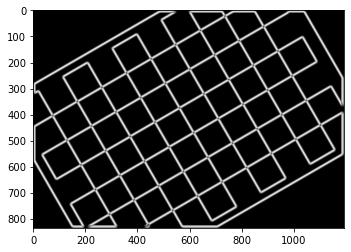

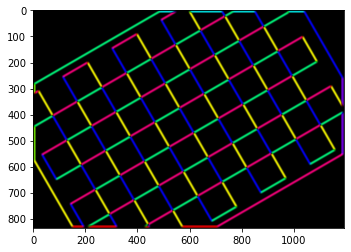

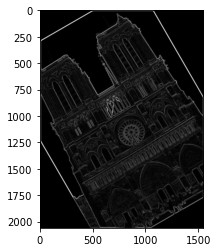

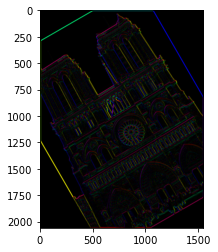

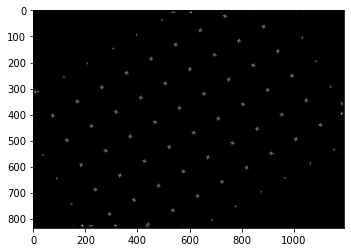

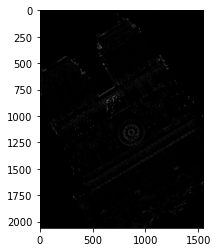

True

In [47]:
chess_image_rotate = signal.convolve2d(chess_image_rotate, G_5)
notredame_a_rotate = signal.convolve2d(notredame_a_rotate, G_5)
dx_c_r, dy_c_r, magnitude_c_r, theta_c_r, direction_c_r = sobel(chess_image_rotate)
dx_a_r, dy_a_r, magnitude_a_r, theta_a_r, direction_a_r = sobel(notredame_a_rotate)
# cv2.imwrite('chess_rotate_magnitude_5.png', magnitude_c_r*255 / magnitude_c_r.max())
# cv2.imwrite('chess_rotate_direction_5.png', direction_c_r*255 / direction_c_r.max())
# cv2.imwrite('1a_notredame_rotate_magnitude_5.png', magnitude_a_r*255 / magnitude_a_r.max())
# cv2.imwrite('1a_notredame_rotate_direction_5.png', direction_a_r*255 / direction_a_r.max())


Axx_c_5_r,Axy_c_5_r,Ayy_c_5_r,responce_c_5_r, landa2_c_5_r = structure_matrix(size = 5, dx=dx_c_r, dy=dy_c_r)
Axx_a_5_r,Axy_a_5_r,Ayy_a_5_r,responce_a_5_r, landa2_a_5_r = structure_matrix(size = 5, dx=dx_a_r, dy=dy_a_r)
# cv2.imwrite('chess_rotate_structure_tensor_5.png', landa2_c_5_r*255 / landa2_c_5_r.max())
# cv2.imwrite('1a_notredame_rotate_structure_tensor_5.png', landa2_a_5_r*255 / landa2_a_5_r.max() )

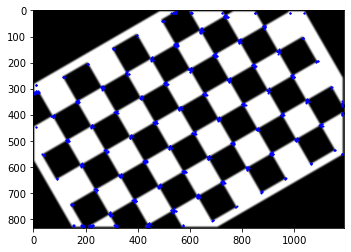

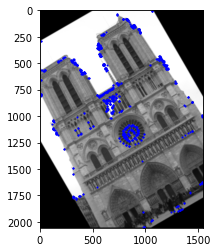

In [48]:
# Chess rotated image
#Non-maximal Suppression
# size=3
r,c =  NMS(responce_c_5_r)
fig, ax = plt.subplots()
ax.imshow(chess_image_rotate, cmap="gray")
ax.plot(c,r,'b.', markersize=2)
plt.savefig('chess_rotate_NMS.png')
plt.show()

# notredame_a rotated image
#Non-maximal Suppression
# size=3
r,c =  NMS(responce_a_5_r)
fig, ax = plt.subplots()
ax.imshow(notredame_a_rotate, cmap="gray")
ax.plot(c,r,'b.', markersize=2)
plt.savefig('1a_notredame_rotate_NMS.png')
plt.show()

###### scale

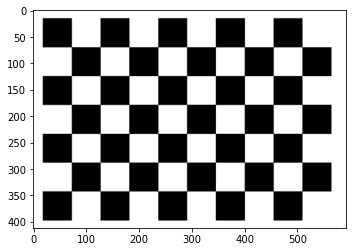

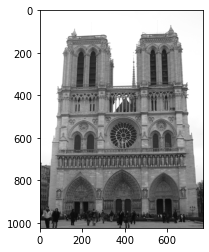

In [49]:
# Chess scale
chess_scale = cv2.resize(chess_img, (0,0), fx=0.5, fy=0.5)
notredame_scale = cv2.resize(notredame_a, (0,0), fx=0.5, fy=0.5)
chess_scale = cv2.cvtColor(chess_scale, cv2.COLOR_RGB2GRAY)
notredame_scale = cv2.cvtColor(notredame_scale, cv2.COLOR_RGB2GRAY)

plt.imshow(chess_scale, cmap="gray")
plt.savefig('chess_scale.png')
plt.show()
plt.imshow(notredame_scale,cmap="gray")
plt.savefig('1a_notredame_scale.png')
plt.show()

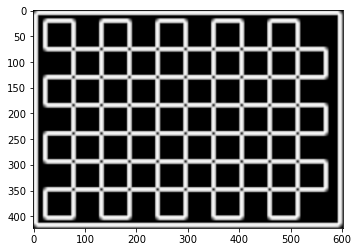

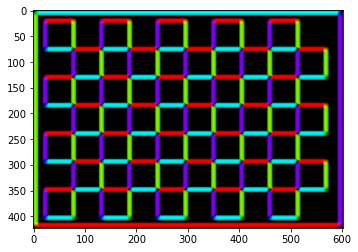

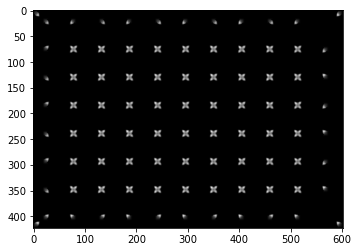

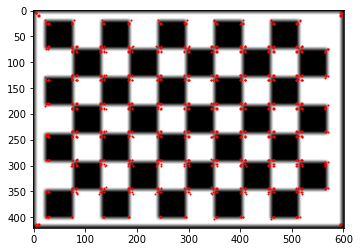

In [50]:
# Chess scale corner detection
chess_scale = signal.convolve2d(chess_scale, G_5)
dx_c_s, dy_c_s, magnitude_c_s, theta_c_s, direction_c_s = sobel(chess_scale)
Axx_c_5_s,Axy_c_5_s,Ayy_c_5_s,responce_c_5_s, landa2_c_5_s = structure_matrix(size = 5, dx=dx_c_s, dy=dy_c_s)
# cv2.imwrite('chess_scale_magnitude_5.png', magnitude_c_s*255 / magnitude_c_s.max())
# cv2.imwrite('chess_scale_direction_5.png', direction_c_s*255 / direction_c_s.max())
# cv2.imwrite('chess_scale_structure_tensor_5.png', landa2_c_5_s*255 / landa2_c_5_s.max())

r,c =  NMS(responce_c_5_s)
fig, ax = plt.subplots()
ax.imshow(chess_scale, cmap="gray")
ax.plot(c,r,'r.', markersize=2)
plt.savefig('chess_scale_NMS.png')
plt.show()


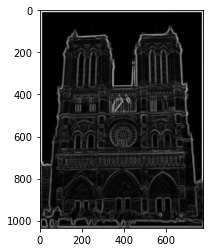

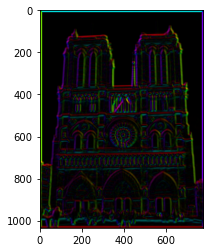

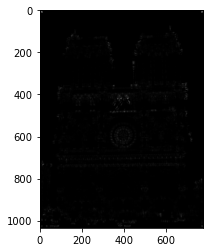

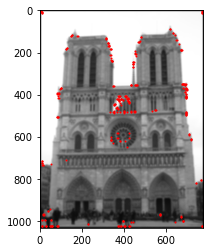

In [51]:
# notredame scale corner detection
notredame_scale = signal.convolve2d(notredame_scale, G_5)
dx_a_s, dy_a_s, magnitude_a_s, theta_a_s, direction_a_s = sobel(notredame_scale)
Axx_a_5_s,Axy_a_5_s,Ayy_a_5_s,responce_a_5_s, landa2_a_5_s = structure_matrix(size = 5, dx=dx_a_s, dy=dy_a_s)
cv2.imwrite('1a_notredame_scale_magnitude_5.png', magnitude_a_s*255 / magnitude_a_s.max())
cv2.imwrite('1a_notredame_scale_direction_5.png', direction_a_s*255 / direction_a_s.max())
cv2.imwrite('1a_notredame_scale_structure_tensor_5.png', landa2_a_5_s*25 / landa2_a_5_s.max())

r,c =  NMS(responce_a_5_s)
fig, ax = plt.subplots()
ax.imshow(notredame_scale, cmap="gray")
ax.plot(c,r,'r.', markersize=2)
plt.savefig('1a_notredame_scale_NMS.png')
plt.show()

# Discussion

###### a.  Discuss the results of blurred images and detected edge between different kernel sizes of Gaussian filter.


* 從上面實作結果能夠觀察到，Gaussian filter其window size 越大，對於平滑效果與去躁化效果更為顯著，同時模糊效果也更加明顯。
* 然而在 detected edge 方面卻恰其相反，從結果得知，windoe size越小越能夠有較清晰的邊緣化偵測。

###### b.  Difference between 3x3 and 5x5 window sizes of structure tensor.


* 相比3X3 window size 下，5X5 window size 最終呈現的2X2 pixel 值包含更大範圍的運算，這也導致之後所做的harris corner response 能夠更加明顯的偵測到gradient的劇烈變化而發現corner

###### c.   The effect of non-maximal suppression.

* 再corner detection時，會有許多點都有很高的gradient，NMS能夠透過threshold先將過低的corner responce淘汰掉，再透過local中找尋最大值
* 因此，當threshold越高時，corner被NMS篩選出來的就會越少；同時若取的local size越高，也會因為在更大的範圍選maximum導致corner 適量減少

##### d. Discuss the result from (B). Is Harris detector rotation-invariant or scale-invariant?

* 從實驗結果來看，在相同的參數下，scale後的圖片其corner 會相對減少許多
* 因此，Harris detector 為 scale-invariant

---
---
---

## 1-2


#### (a) SIFT interest point detection
* Apply SIFT interest point detector (functions from OpenCV) to the following two images
* Adjust the related thresholds in SIFT detection such that there are around 100 interest points detected in each image .
* Plot the detected interest points on the corresponding images


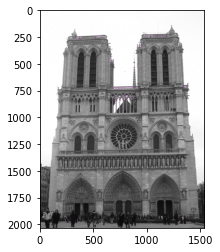

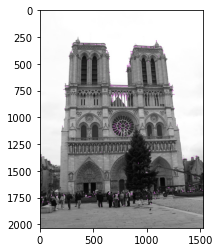

[INFO] la_notredame of keypoints detected: 200
[INFO] lb_notredame of keypoints detected: 559
[INFO] feature vector shape: (200, 128)
[INFO] feature vector shape: (559, 128)


In [24]:
### HW 1-2 ###
"""
2(A)
"""
similarity, img3, kp1, des1, kp2, des2, img1, img2 = SIFT(notredame_a, notredame_b, notredame_a_gray, notredame_b_gray)

#### (b) SIFT feature matching
* Compare the similarity between all the pairs between the detected interest points from each of the two images based on a suitable distance function between two SIFT feature vectors
* Implement a function that finds a list of interest point correspondences based on nearest-neighbor matching principle
*  Plot the point correspondences (from the previous step) overlaid on the pair of original images

In [31]:
"""
2(b)
"""
# Similarity
# Calculated by SIFT function
# Similarity = a.b / |a| * |b|
print(similarity)


# match function
matches = match(similarity, kp1, kp2)

[[0.6024242  0.56047851 0.83430612 ... 0.73799318 0.76495177 0.76144153]
 [0.65043896 0.49992377 0.73422754 ... 0.72099304 0.73266935 0.7260772 ]
 [0.48084068 0.57046998 0.79172659 ... 0.7185362  0.82158959 0.82026953]
 ...
 [0.3757976  0.37014523 0.26550868 ... 0.20637999 0.19979922 0.18715909]
 [0.36106679 0.33766204 0.29832292 ... 0.22490242 0.22682631 0.22453961]
 [0.35434353 0.33512551 0.25046563 ... 0.19918947 0.18448707 0.17338404]]
The number of matches: 200


#### Plot the image

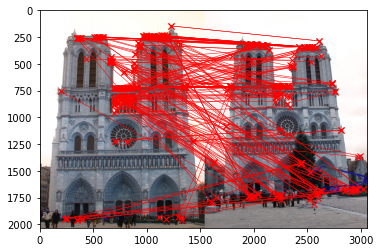

In [32]:
plot_matches(matches, img3)

#### (c)  Discussion
* Discuss the cases of mis-matching in the point correspondence
* Discuss and implement possible solutions to reduce the mis-matches, and show your results. 


In [27]:
"""
2(c) Discuss the cases of mis-matching in the point correspondence
"""

'\n2(c) Discuss the cases of mis-matching in the point correspondence\n'

* Those which are matching better 

The number of matches: 28


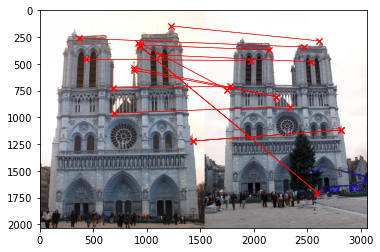

In [28]:
"""
2(c) Discuss and implement possible solutions to reduce the mis-matches, and show your results.
"""
matches = improve_match(similarity, kp1, kp2)
plot_matches(matches, img3)

# Discussion

##### a. Discuss the cases of mis-matching in the point correspondences

* 在許多相似的區塊，例如左右兩邊的塔，有許多點皆被錯誤的match，像是左邊的塔連到右邊的塔，或是第二根短柱連到第五根短柱
* 同時也有許多黑色區塊被互相配對但皆不是正確的匹配

##### b. Discuss and implement possible solutions to reduce the mis-matches, and show your results.

* 再經過k個最近鄰居的探索後，得到距離最短的k個描述特徵距離。
* 我實作了ratio test 的作法
* 我們將第二最短距離以上的點視為隨機配對結果，意即視為negative的配對
* 倘若最短距離與negative差距大於某個threshold，代表此最短距離與negative相距甚大，我們就將此點視為示好的match
* 反之，若距離不夠遠，意味著此點與negative蠻接近的，我們就是此點為不好的match並且不採用此點
* 從結果來看，非常大幅度的去掉了mis-matching的點，留下的大部分皆為正確的配對。然而也有許多正確的match被犧牲了